# Deep Learning Bootcamp November 2017, GPU Computing for Data Scientists

<img src="../images/bcamp.png" align="center">

### 55 PyTorch Convolutional Nerual Network (CNN) classifier for Numer.Ai Binary Classification problem using CONV1D (one dimentional convolution). 

Web: https://www.meetup.com/Tel-Aviv-Deep-Learning-Bootcamp/events/241762893/

Notebooks: <a href="https://github.com/QuantScientist/Data-Science-PyCUDA-GPU"> On GitHub</a>

*Shlomo Kashani*

<img src="../images/pt.jpg" width="35%" align="center">


### Data
- Download from https://numer.ai/leaderboard

<img src="../images/Numerai.png" width="35%" align="center">

# Why are we doing this? 

## One dimetional CNN? Convolutional Nerual Network (CNN) using one dimentional convolution (CONV1D).

- Indeed, most of the existing PyTorch examples are using Images, while here we have a CSV with 21 features. Using CONV1D *before or after a Lineer layer* requires the use of **reshaping**, and this is the **whole point of this tutorial**. 

- Thus, the CNN architecture is naive and by no means **optimized**. Hopefully, I will improve it over time and I am working on a second CNN based version of the same problem. 


## Introduction

- This tutorial was written in order to demonstrate a **fully working** example of a PyTorch **CNN** on a real world use case, namely a Binary Classification problem. 

- If you are interested in the sk-learn version of this problem please refer to: https://github.com/QuantScientist/deep-ml-meetups/tree/master/hacking-kaggle/python/numer-ai 

- For the scientific foundation behind Binary Classification and Logistic Regression, refer to: https://github.com/QuantScientist/Deep-Learning-Boot-Camp/tree/master/Data-Science-Interviews-Book

- Every step, from reading the CSV into numpy arrays, converting to GPU based tensors, training and validation, are meant to aid newcomers in their first steps in PyTorch. 

- Additionally, commonly used Kaggle metrics such as ROC_AUC and LOG_LOSS are logged and plotted both for the training set as well as for the validation set. 

# PyTorch Imports


In [1]:
# !pip install pycuda
%reset -f

import torch
from torch.autograd import Variable
import numpy as np
import pandas
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split
import logging
import numpy
import numpy as np
from __future__ import print_function
from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MultiLabelBinarizer
import time
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import numpy as np
import scipy
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)      # setting default size of plots
import tensorflow as tf 
print("tensorflow:" + tf.__version__)
!set "KERAS_BACKEND=tensorflow"
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')

# !pip install http://download.pytorch.org/whl/cu75/torch-0.2.0.post1-cp27-cp27mu-manylinux1_x86_64.whl
# !pip install torchvision 
# ! pip install cv2
# import cv2

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("PyTorch: ", torch.__version__)
print("Numpy: ", np.__version__)

handler=logging.basicConfig(level=logging.INFO)
lgr = logging.getLogger(__name__)
%matplotlib inline

# !pip install psutil
import psutil

import torch
import gc

def memReport():
    for obj in gc.get_objects():
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    
def cpuStats():
        print(sys.version)
        print(psutil.cpu_percent())
        print(psutil.virtual_memory())  # physical memory usage
        pid = os.getpid()
        py = psutil.Process(pid)
        memoryUse = py.memory_info()[0] / 2. ** 30  # memory use in GB...I think
        print('memory GB:', memoryUse)

cpuStats()
memReport()

# %%timeit
use_cuda = torch.cuda.is_available()
# use_cuda = False

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

use_cuda=False
lgr.info("USE CUDA=" + str (use_cuda))

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


tensorflow:1.2.1
__Python VERSION: 2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]
__pyTorch VERSION: 0.2.0+42448cf
__CUDA VERSION
__CUDNN VERSION: None
__Number CUDA Devices: 1
__Devices
OS:  linux2
Python:  2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]
PyTorch:  0.2.0+42448cf
Numpy:  1.13.1
2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]
0.0
svmem(total=67469099008, available=59164618752, percent=12.3, used=7518400512, free=55430684672, active=9432064000, inactive=1441492992, buffers=999534592, cached=3520479232, shared=237813760)
memory GB: 0.222640991211


INFO:__main__:USE CUDA=False


#  Global params

In [2]:

# fix seed
seed=17*19
np.random.seed(seed)
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)    

#  View the Data
- Numerai provides a data set that is allready split into train, validation and test sets. 

In [3]:
# Data params
TARGET_VAR= 'target'
TOURNAMENT_DATA_CSV = 'numerai_tournament_data.csv'
TRAINING_DATA_CSV = 'numerai_training_data.csv'
BASE_FOLDER = 'numerai/'

df_train = pd.read_csv(BASE_FOLDER + TRAINING_DATA_CSV)
df_train.head(5)

,id,era,data_type,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,target
0,72774,era1,train,0.48937,0.56969,0.59150,0.46432,0.42291,0.49616,0.53542,...,0.42195,0.62651,0.51604,0.42938,0.56744,0.60008,0.46966,0.50322,0.42803,1
1,140123,era1,train,0.57142,0.43408,0.58771,0.44570,0.41471,0.49137,0.52791,...,0.46301,0.55103,0.39053,0.48856,0.54305,0.59213,0.44935,0.56685,0.59645,1
2,46882,era1,train,0.75694,0.59942,0.36154,0.65571,0.60520,0.45317,0.49847,...,0.68057,0.43763,0.46322,0.63211,0.32947,0.35632,0.56316,0.33888,0.40120,0
3,20833,era1,train,0.46059,0.50856,0.64215,0.41382,0.39550,0.49282,0.54697,...,0.38108,0.65446,0.54926,0.36297,0.61482,0.64292,0.52910,0.53582,0.47027,0
4,5381,era1,train,0.61195,0.66684,0.45877,0.56730,0.51889,0.41257,0.56030,...,0.54803,0.59120,0.58160,0.51828,0.43870,0.47011,0.56007,0.36374,0.31552,1


#  Train / Validation / Test Split
- Numerai provides a data set that is allready split into train, validation and test sets. 

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from collections import defaultdict
# Train, Validation, Test Split
def loadDataSplit():
    df_train = pd.read_csv(BASE_FOLDER + TRAINING_DATA_CSV)
    # TOURNAMENT_DATA_CSV has both validation and test data provided by NumerAI
    df_test_valid = pd.read_csv(BASE_FOLDER + TOURNAMENT_DATA_CSV)

    answers_1_SINGLE = df_train[TARGET_VAR]
    df_train.drop(TARGET_VAR, axis=1,inplace=True)
    df_train.drop('id', axis=1,inplace=True)
    df_train.drop('era', axis=1,inplace=True)
    df_train.drop('data_type', axis=1,inplace=True)    

    df_train.to_csv(BASE_FOLDER + TRAINING_DATA_CSV + 'clean.csv', header=False,  index = False)    
    df_train= pd.read_csv(BASE_FOLDER + TRAINING_DATA_CSV + 'clean.csv', header=None, dtype=np.float32)    
    df_train = pd.concat([df_train, answers_1_SINGLE], axis=1)
    feature_cols = list(df_train.columns[:-1])
    target_col = df_train.columns[-1]
    trainX, trainY = df_train[feature_cols], df_train[target_col]
    
        
    df_validation_set=df_test_valid.loc[df_test_valid['data_type'] == 'validation'] 
    df_validation_set=df_validation_set.copy(deep=True)
    answers_1_SINGLE_validation = df_validation_set[TARGET_VAR]
    df_validation_set.drop(TARGET_VAR, axis=1,inplace=True)    
    df_validation_set.drop('id', axis=1,inplace=True)
    df_validation_set.drop('era', axis=1,inplace=True)
    df_validation_set.drop('data_type', axis=1,inplace=True)
    
        
    df_validation_set.to_csv(BASE_FOLDER + TRAINING_DATA_CSV + '-validation-clean.csv', header=False,  index = False)    
    df_validation_set= pd.read_csv(BASE_FOLDER + TRAINING_DATA_CSV + '-validation-clean.csv', header=None, dtype=np.float32)    
    df_validation_set = pd.concat([df_validation_set, answers_1_SINGLE_validation], axis=1)
    feature_cols = list(df_validation_set.columns[:-1])

    target_col = df_validation_set.columns[-1]
    valX, valY = df_validation_set[feature_cols], df_validation_set[target_col]
                                
    df_test_set = pd.read_csv(BASE_FOLDER + TOURNAMENT_DATA_CSV)
    df_test_set=df_test_set.copy(deep=True)
    df_test_set.drop(TARGET_VAR, axis=1,inplace=True)
    tid_1_SINGLE = df_test_set['id']
    df_test_set.drop('id', axis=1,inplace=True)
    df_test_set.drop('era', axis=1,inplace=True)
    df_test_set.drop('data_type', axis=1,inplace=True)   
        
    feature_cols = list(df_test_set.columns) # must be run here, we dont want the ID    
    df_test_set = pd.concat([tid_1_SINGLE, df_test_set], axis=1)            
    testX = df_test_set[feature_cols].values
        
    return trainX, trainY, valX, valY, testX, df_test_set


trainX, trainY, valX, valY, testX, df_test_set = loadDataSplit()
trainX.head(5) # with new features added

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.48937,0.56969,0.59150,0.46432,0.42291,0.49616,0.53542,0.50577,0.31534,0.58043,...,0.46203,0.42195,0.62651,0.51604,0.42938,0.56744,0.60008,0.46966,0.50322,0.42803
1,0.57142,0.43408,0.58771,0.44570,0.41471,0.49137,0.52791,0.42731,0.52087,0.40264,...,0.37833,0.46301,0.55103,0.39053,0.48856,0.54305,0.59213,0.44935,0.56685,0.59645
2,0.75694,0.59942,0.36154,0.65571,0.60520,0.45317,0.49847,0.25173,0.52677,0.47626,...,0.64442,0.68057,0.43763,0.46322,0.63211,0.32947,0.35632,0.56316,0.33888,0.40120
3,0.46059,0.50856,0.64215,0.41382,0.39550,0.49282,0.54697,0.51875,0.30797,0.55321,...,0.42176,0.38108,0.65446,0.54926,0.36297,0.61482,0.64292,0.52910,0.53582,0.47027
4,0.61195,0.66684,0.45877,0.56730,0.51889,0.41257,0.56030,0.39115,0.32634,0.62694,...,0.61730,0.54803,0.59120,0.58160,0.51828,0.43870,0.47011,0.56007,0.36374,0.31552


#  From Numpy to PyTorch GPU tensors

In [5]:
# Convert the np arrays into the correct dimention and type
# Note that BCEloss requires Float in X as well as in y
def XnumpyToTensor(x_data_np):
    x_data_np = np.array(x_data_np.values, dtype=np.float32)        
    print(x_data_np.shape)
    print(type(x_data_np))

    if use_cuda:
        lgr.info ("Using the GPU")    
        X_tensor = Variable(torch.from_numpy(x_data_np).cuda()) # Note the conversion for pytorch    
    else:
        lgr.info ("Using the CPU")
        X_tensor = Variable(torch.from_numpy(x_data_np)) # Note the conversion for pytorch
    
    print(type(X_tensor.data)) # should be 'torch.cuda.FloatTensor'            
    print((X_tensor.data.shape)) # torch.Size([108405, 29])
    return X_tensor


# Convert the np arrays into the correct dimention and type
# Note that BCEloss requires Float in X as well as in y
def YnumpyToTensor(y_data_np):    
    y_data_np=y_data_np.reshape((y_data_np.shape[0],1)) # Must be reshaped for PyTorch!
    print(y_data_np.shape)
    print(type(y_data_np))

    if use_cuda:
        lgr.info ("Using the GPU")            
    #     Y = Variable(torch.from_numpy(y_data_np).type(torch.LongTensor).cuda())
        Y_tensor = Variable(torch.from_numpy(y_data_np)).type(torch.FloatTensor).cuda()  # BCEloss requires Float        
    else:
        lgr.info ("Using the CPU")        
    #     Y = Variable(torch.squeeze (torch.from_numpy(y_data_np).type(torch.LongTensor)))  #         
        Y_tensor = Variable(torch.from_numpy(y_data_np)).type(torch.FloatTensor)  # BCEloss requires Float        

    print(type(Y_tensor.data)) # should be 'torch.cuda.FloatTensor'
    print(y_data_np.shape)
    print(type(y_data_np))    
    return Y_tensor

# CNN Architecture


# How conv1d works? 

- conv = torch.nn.Conv1d(in_channels=5, out_channels=10, kernel_size=2)

- Note that view is only supposed to work on contiguous tensors, and transposing a tensor makes it non-contiguous. You can use .contiguous() after transpose 

- Note that Conv1d expects (batch, in_channels, in_length).

In [6]:
# n_input n_cnn_kernel n_padding n_input_rows n_hidden     after CNN                      stride
# 21      1            1         108405       21*32=672    torch.Size([108405, 672, 3]    1
# 21      1            2         108405       21*32=672    torch.Size([108405, 672, 5]    
# 21      1            3         108405       21*32=672    torch.Size([108405, 672, 7]
# 21      1            4         108405       21*32=672    torch.Size([108405, 672, 9]

# 21      2            1         108405       21*32=672    torch.Size([108405, 672, 2]
# 21      3            1         108405       21*32=672    torch.Size([108405, 672, 1]
# 21      4            1         108405       21*32=672    ERROR * ERROR * ERROR 
# Given input size: (21 x 1 x 1). 
# Calculated output size: (672 x 1 x 0). Output size is too small 

# 21      2            2         108405       21*32=672    torch.Size([108405, 672, 4]
# 21      3            2         108405       21*32=672    torch.Size([108405, 672, 3]
# 21      4            2         108405       21*32=672    torch.Size([108405, 672, 2]
# 21      5            2         108405       21*32=672    torch.Size([108405, 672, 1]
# 21      6            2         108405       21*32=672    ERROR * ERROR * ERROR

# 21      1            3         108405       21*32=672    torch.Size([108405, 672, 7]
# 21      2            3         108405       21*32=672    torch.Size([108405, 672, 6]
# 21      3            3         108405       21*32=672    torch.Size([108405, 672, 5]
# 21      4            3         108405       21*32=672    torch.Size([108405, 672, 4]
# 21      5            3         108405       21*32=672    torch.Size([108405, 672, 3]
# 21      6            3         108405       21*32=672    torch.Size([108405, 672, 2]
# 21      7            3         108405       21*32=672    torch.Size([108405, 672, 1]


# 21      4            4         108405       21*32=672    torch.Size([108405, 672, 6]
# 21      5            4         108405       21*32=672    torch.Size([108405, 672, 5]
# 21      6            4         108405       21*32=672    torch.Size([108405, 672, 4]
# 21      7            4         108405       21*32=672    torch.Size([108405, 672, 3]
# 21      8            4         108405       21*32=672    torch.Size([108405, 672, 2]
# 21      9            4         108405       21*32=672    torch.Size([108405, 672, 1]


# 21      4            4         108405       21*32=672    torch.Size([108405, 672, 3]   2
# 21      5            4         108405       21*32=672    torch.Size([108405, 672, 3]   2
# 21      6            4         108405       21*32=672    torch.Size([108405, 672, 2]   2



In [7]:
loss_func=torch.nn.BCELoss() # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss

# References:
# https://github.com/vinhkhuc/PyTorch-Mini-Tutorials/blob/master/5_convolutional_net.py
# https://gist.github.com/spro/c87cc706625b8a54e604fb1024106556

X_tensor_train= XnumpyToTensor(trainX) # default order is NBC for a 3d tensor, but we have a 2d tensor
X_shape=X_tensor_train.data.size()


# 21      6            3         108405       21*32=672    torch.Size([108405, 672, 2] n_max_pool1d=1
# torch.Size([108405, 21])
# after view, (size():torch.Size([108405, 21, 1])
# after CNN, (size():torch.Size([108405, 504, 2])
# after 2nd view, (size():torch.Size([108405, 1008])
# after self.out, (size():torch.Size([108405, 1])
# (b.size():torch.Size([108405, 1])


n_mult_factor=5
n_input= trainX.shape[1]
n_hidden= n_input * n_mult_factor
n_output=1
n_input_rows=trainX.shape[0]
n_cnn_kernel=4
n_padding=3

n_max_pool1d=2

DEBUG_ON=True
def debug(msg, x):
    if DEBUG_ON:
        print (msg + ', (size():' + str (x.size()))
    
class CNNNumerAI(nn.Module):    
    def __init__(self, n_input, n_hidden, n_output,n_cnn_kernel, n_mult_factor, n_padding,n_max_pool1d):
        super(CNNNumerAI, self).__init__()    
        self.n_input=n_input
        self.n_hidden=n_hidden
        self.n_output= n_output 
        self.n_cnn_kernel=n_cnn_kernel
        self.n_mult_factor=n_mult_factor
        self.n_padding=n_padding
        self.n_max_pool1d=n_max_pool1d
        self.n_l1=int((n_mult_factor * self.n_input) * (n_padding + 1) / n_max_pool1d)
        
        self.c1 = nn.Sequential(
            torch.nn.Conv1d(self.n_input, self.n_hidden, 
                                kernel_size=(self.n_cnn_kernel,), stride=(1,), padding=(self.n_padding,)),                                             
            torch.nn.Dropout(),
            torch.nn.MaxPool1d(kernel_size=self.n_max_pool1d),
            torch.nn.ReLU(),            

            
            
            torch.nn.Conv1d(self.n_hidden, self.n_hidden, 
                                kernel_size=(self.n_cnn_kernel,), stride=(1,), padding=(self.n_padding,)),                                             
            torch.nn.Dropout(),
            torch.nn.MaxPool1d(kernel_size=self.n_max_pool1d),
            torch.nn.ReLU(),                
            
            torch.nn.Conv1d(self.n_hidden, self.n_hidden, 
                                kernel_size=(self.n_cnn_kernel,), stride=(1,), padding=(self.n_padding,)),                                             
            torch.nn.Dropout(),
            torch.nn.MaxPool1d(kernel_size=self.n_max_pool1d),
            torch.nn.ReLU(),                
            
            
            
        )                 
        self.fc1 = nn.Sequential(
#             torch.nn.Linear(self.n_l1,int(self.n_l1/2)),
            torch.nn.Linear(self.n_hidden*2,self.n_output)
            
#             torch.nn.ReLU(),
#             torch.nn.Dropout(),            
            
#             torch.nn.Linear(int(self.n_l1/2),int(self.n_l1/4)),        
#             torch.nn.ReLU(),
#             torch.nn.Dropout(),            
            
#             torch.nn.Linear(int(self.n_l1/4), self.n_output),            
        )                                
        self.sig=nn.Sigmoid()
                
        
    def forward(self, x):
#         debug('raw',x)   
        varSize=x.data.shape[0] # must be calculated here in forward() since its is a dynamic size                          
        # for CNN  
        x=x.contiguous() 
        x = x.view(varSize,self.n_input,1)
#         debug('after view',x)   
        x=self.c1(x)
#         debug('after CNN',x)   
        # for Linear layer
#         x = x.view(varSize,self.n_l1) 
        x = x.view(varSize,self.n_hidden*2) 
#         debug('after 2nd view',x)          
#         x=self.l2(x)                    
        x=self.fc1(x)   
#         debug('after self.out',x)   
        x=self.sig(x)
        return x

net = CNNNumerAI(n_input, n_hidden, n_output,n_cnn_kernel, n_mult_factor, n_padding, n_max_pool1d)    
if use_cuda:
    net=net.cuda() 
lgr.info(net)
b = net(X_tensor_train)
print ('(b.size():' + str (b.size())) 

INFO:__main__:Using the CPU
INFO:__main__:CNNNumerAI (
  (c1): Sequential (
    (0): Conv1d(21, 105, kernel_size=(4,), stride=(1,), padding=(3,))
    (1): Dropout (p = 0.5)
    (2): MaxPool1d (size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU ()
    (4): Conv1d(105, 105, kernel_size=(4,), stride=(1,), padding=(3,))
    (5): Dropout (p = 0.5)
    (6): MaxPool1d (size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU ()
    (8): Conv1d(105, 105, kernel_size=(4,), stride=(1,), padding=(3,))
    (9): Dropout (p = 0.5)
    (10): MaxPool1d (size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU ()
  )
  (fc1): Sequential (
    (0): Linear (210 -> 1)
  )
  (sig): Sigmoid ()
)


(108405, 21)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'>
torch.Size([108405, 21])
(b.size():torch.Size([108405, 1])


In [8]:
# NN params
LR = 0.005
MOMENTUM= 0.9

# optimizer = torch.optim.SGD(net.parameters(), lr=0.02)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=5e-4)
# optimizer = torch.optim.Adam(net.parameters(), lr=LR,weight_decay=5e-4) #  L2 regularization
if use_cuda:
    lgr.info ("Using the GPU")    
    net.cuda()
    loss_func.cuda()

lgr.info (optimizer)
lgr.info (loss_func)

INFO:__main__:<torch.optim.sgd.SGD object at 0x7fe5743e5990>
INFO:__main__:BCELoss (
)


# Training set

INFO:__main__:Using the CPU
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
INFO:__main__:Using the CPU


(108405, 21)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'>
torch.Size([108405, 21])
(108405, 1)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'>
(108405, 1)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'> <class 'torch.FloatTensor'>
0 [ 0.69325662]
ACC=0.0, LOG_LOSS=0.693318186223, ROC_AUC=0.498879522411 
10 [ 0.69331521]
ACC=0.0, LOG_LOSS=0.693298360626, ROC_AUC=0.499274270476 
20 [ 0.69322312]
ACC=0.0, LOG_LOSS=0.693255513259, ROC_AUC=0.50216418131 
30 [ 0.69325554]
ACC=0.0, LOG_LOSS=0.693335078244, ROC_AUC=0.497627199571 
40 [ 0.69321662]
ACC=0.0, LOG_LOSS=0.693280178888, ROC_AUC=0.499195263574 
50 [ 0.69321948]
ACC=0.0, LOG_LOSS=0.693289057838, ROC_AUC=0.498991235113 
60 [ 0.69324064]
ACC=0.0, LOG_LOSS=0.69331055209, ROC_AUC=0.49795403732 
70 [ 0.69325197]
ACC=0.0, LOG_LOSS=0.693231185516, ROC_AUC=0.501287061178 
80 [ 0.6932258]
ACC=0.0, LOG_LOSS=0.693189212006, ROC_AUC=0.502128969814 
90 [ 0.6932044]
ACC=0.0, LOG_LOSS=0.693230688928, ROC_AUC=0.50097413718 
100 [ 0.693287

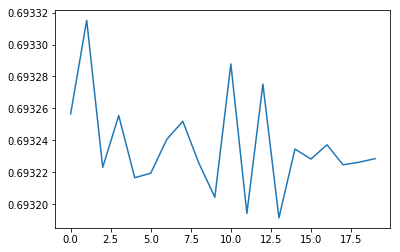

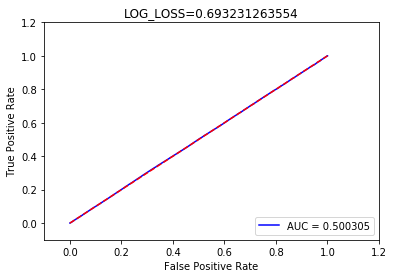

In [9]:
import time
start_time = time.time()    
epochs=200
all_losses = []

DEBUG_ON=True

X_tensor_train= XnumpyToTensor(trainX)
Y_tensor_train= YnumpyToTensor(trainY)

print(type(X_tensor_train.data), type(Y_tensor_train.data)) # should be 'torch.cuda.FloatTensor'

# From here onwards, we must only use PyTorch Tensors
for step in range(epochs):
    out = net(X_tensor_train)                 # input x and predict based on x
    cost = loss_func(out, Y_tensor_train)     # must be (1. nn output, 2. target), the target label is NOT one-hotted

    optimizer.zero_grad()   # clear gradients for next train
    cost.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
                           
    if step % 10 == 0:        
        loss = cost.data[0]
        all_losses.append(loss)
        print(step, cost.data.cpu().numpy())        
        prediction = (net(X_tensor_train).data).float() # probabilities             
        pred_y = prediction.cpu().numpy().squeeze()
        target_y = Y_tensor_train.cpu().data.numpy()                        
        tu = ((pred_y == target_y).mean(),log_loss(target_y, pred_y),roc_auc_score(target_y,pred_y ))
        print ('ACC={}, LOG_LOSS={}, ROC_AUC={} '.format(*tu))        
                
end_time = time.time()
print ('{} {:6.3f} seconds'.format('GPU:', end_time-start_time))

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(all_losses)
plt.show()

false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y,pred_y)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('LOG_LOSS=' + str(log_loss(target_y, pred_y)))
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Validation set + ROC_AUC

INFO:__main__:Using the CPU
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
INFO:__main__:Using the CPU


(16686, 21)
(16686,)
(16686, 21)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'>
torch.Size([16686, 21])
(16686, 1)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'>
(16686, 1)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'> <class 'torch.FloatTensor'>
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>


acc=0.0 log_loss=0.693369296451 roc_auc=0.506511358873 


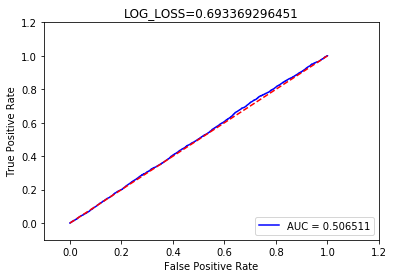

In [10]:
net.eval()
# Validation data
print (valX.shape)
print (valY.shape)

X_tensor_val= XnumpyToTensor(valX)
Y_tensor_val= YnumpyToTensor(valY)


print(type(X_tensor_val.data), type(Y_tensor_val.data)) # should be 'torch.cuda.FloatTensor'

predicted_val = (net(X_tensor_val).data).float() # probabilities 
# predicted_val = (net(X_tensor_val).data > 0.5).float() # zero or one
pred_y = predicted_val.cpu().numpy()
target_y = Y_tensor_val.cpu().data.numpy()                

print (type(pred_y))
print (type(target_y))

tu = (str ((pred_y == target_y).mean()),log_loss(target_y, pred_y),roc_auc_score(target_y,pred_y ))
print ('\n')
print ('acc={} log_loss={} roc_auc={} '.format(*tu))

false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y,pred_y)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('LOG_LOSS=' + str(log_loss(target_y, pred_y)))
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# print (pred_y)

# Test set + Submission file for Numerai

In [11]:
print (df_test_set.shape)
columns = ['id', 'probability']
df_pred=pd.DataFrame(data=np.zeros((0,len(columns))), columns=columns)
df_pred.id.astype(int)

for index, row in df_test_set.iterrows():
    rwo_no_id=row.drop('id')    
#     print (rwo_no_id.values)    
    x_data_np = np.array(rwo_no_id.values, dtype=np.float32)        
    if use_cuda:
        X_tensor_test = Variable(torch.from_numpy(x_data_np).cuda()) # Note the conversion for pytorch    
    else:
        X_tensor_test = Variable(torch.from_numpy(x_data_np)) # Note the conversion for pytorch
                    
    X_tensor_test=X_tensor_test.view(1, trainX.shape[1]) # does not work with 1d tensors            
    predicted_val = (net(X_tensor_test).data).float() # probabilities     
    p_test =   predicted_val.cpu().numpy().item() # otherwise we get an array, we need a single float
    
    df_pred = df_pred.append({'id':row['id'].astype(int), 'probability':p_test},ignore_index=True)
    
df_pred.head(5)

(45668, 22)


,id,probability
0,90616.0,0.509536
1,148473.0,0.509103
2,72743.0,0.509280
3,32457.0,0.508585
4,12608.0,0.509052


In [12]:
df_pred.id=df_pred.id.astype(int)

def savePred(df_pred, loss):
#     csv_path = 'pred/p_{}_{}_{}.csv'.format(loss, name, (str(time.time())))
    csv_path = 'pred/pred_{}_{}.csv'.format(loss, (str(time.time())))
    df_pred.to_csv(csv_path, columns=('id', 'probability'), index=None)
    print (csv_path)
    
savePred (df_pred, log_loss(target_y, pred_y))

pred/pred_0.693369296451_1505062879.94.csv
